# Predicción del seguro médico



In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Paso 1: importación del dataset

In [184]:
url='https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'
df=pd.read_csv(url)

### Paso 2: análisis exploratorio

In [185]:
df.sample(10)

,age,sex,bmi,children,smoker,region,charges
412,26,female,17.195,2,yes,northeast,14455.64405
135,22,female,28.050,0,no,southeast,2155.68150
211,40,male,30.875,4,no,northwest,8162.71625
1278,39,male,29.925,1,yes,northeast,22462.04375
142,34,male,25.300,2,yes,southeast,18972.49500
216,53,female,26.600,0,no,northwest,10355.64100
1284,61,male,36.300,1,yes,southwest,47403.88000
14,27,male,42.130,0,yes,southeast,39611.75770
1091,55,female,29.830,0,no,northeast,11286.53870
777,45,male,39.805,0,no,northeast,7448.40395


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [187]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [188]:
obj=df.select_dtypes('object').columns
df[obj]=df[obj].astype('category')

In [189]:
df.describe(include='category')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Se observa que no existen missing values ni parecerían existir valores atípicos a simple vista.

In [190]:
for i in df.select_dtypes('category'):
    print('')
    print('Categorias de ',i)
    print('')
    print(df[i].value_counts(normalize=True))


Categorias de  sex

male      0.505232
female    0.494768
Name: sex, dtype: float64

Categorias de  smoker

no     0.795217
yes    0.204783
Name: smoker, dtype: float64

Categorias de  region

southeast    0.272048
northwest    0.242900
southwest    0.242900
northeast    0.242152
Name: region, dtype: float64


Se observa que la muestra está equilibrada por sexo y región, pero no así por fumadores, hay mayor representación de fumadores. Este desbalance puede llevar a que el modelo no prediga correctamente el impacto de ser fumador en el costo del seguro.

In [191]:
X=df.drop(columns='charges')
y=df['charges']

Se divide la muestra entre entrenamiento y prueba considerando proporciones de 80-20.

In [192]:
from sklearn.model_selection import train_test_split


In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

In [194]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [195]:
df_train=X_train.copy()
df_train['charge']=y_train

In [196]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1070 non-null   int64   
 1   sex       1070 non-null   category
 2   bmi       1070 non-null   float64 
 3   children  1070 non-null   int64   
 4   smoker    1070 non-null   category
 5   region    1070 non-null   category
 6   charge    1070 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 37.1 KB


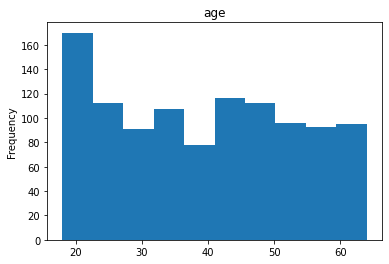

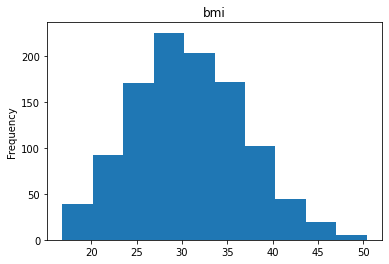

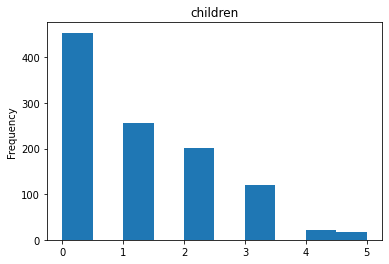

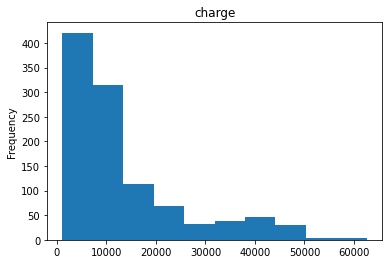

In [197]:
for i in df_train.select_dtypes(['float','int']):
    df_train[i].plot(kind='hist')
    plt.title(i)
    plt.show()


Considerando solo la muestra de entrenamiento, no se detectan valores atípicos que requieran un estudio más profundo.

Para seleccionar las variables a considerar se analiza la correlación lineal entre ellas.

In [198]:
df_train.corr()

,age,bmi,children,charge
age,1.000000,0.098839,0.023512,0.297439
bmi,0.098839,1.000000,0.014912,0.189630
children,0.023512,0.014912,1.000000,0.052584
charge,0.297439,0.189630,0.052584,1.000000


A primera vista la correlación entre las variables explicativas cuantitativas no evidencia existencia de multicolinealidad, siendo esta una buena señal. Al mismo tiempo, se observa que no existe una relación lineal alta entre dichas variables y la variable target. Sin embargo, interesa ver la relación lineal de cada feature cuando se distinguen grupos en función a las variables categóricas.

In [199]:
df_train.groupby('sex')[df_train.columns].corr()

age       bmi  children    charge
sex                                                    
female age       1.000000  0.069650  0.081279  0.309725
       bmi       0.069650  1.000000  0.028828  0.167060
       children  0.081279  0.028828  1.000000  0.061125
       charge    0.309725  0.167060  0.061125  1.000000
male   age       1.000000  0.129392 -0.032611  0.290097
       bmi       0.129392  1.000000 -0.000569  0.206190
       children -0.032611 -0.000569  1.000000  0.043991
       charge    0.290097  0.206190  0.043991  1.000000

In [200]:
df.groupby('smoker')[df.columns].corr()

age       bmi  children   charges
smoker                                                 
no     age       1.000000  0.122638  0.033395  0.627947
       bmi       0.122638  1.000000  0.019208  0.084037
       children  0.033395  0.019208  1.000000  0.138929
       charges   0.627947  0.084037  0.138929  1.000000
yes    age       1.000000  0.059674  0.081183  0.368224
       bmi       0.059674  1.000000 -0.012619  0.806481
       children  0.081183 -0.012619  1.000000  0.035945
       charges   0.368224  0.806481  0.035945  1.000000

In [201]:
df.groupby('region')[df.columns].corr()

age       bmi  children   charges
region                                                    
northeast age       1.000000  0.158684 -0.007530  0.300951
          bmi       0.158684  1.000000 -0.021209  0.231712
          children -0.007530 -0.021209  1.000000  0.067929
          charges   0.300951  0.231712  0.067929  1.000000
northwest age       1.000000  0.102804  0.063832  0.337654
          bmi       0.102804  1.000000  0.083024  0.181073
          children  0.063832  0.083024  1.000000  0.160382
          charges   0.337654  0.181073  0.160382  1.000000
southeast age       1.000000  0.019731  0.116481  0.310593
          bmi       0.019731  1.000000 -0.034462  0.142994
          children  0.116481 -0.034462  1.000000  0.046431
          charges   0.310593  0.142994  0.046431  1.000000
southwest age       1.000000  0.212355 -0.008655  0.258358
          bmi       0.212355  1.000000  0.065811  0.222928
          children -0.008655  0.065811  1.000000  0.028188
          charges   0.258358  0.222928  0.028188  1.000000

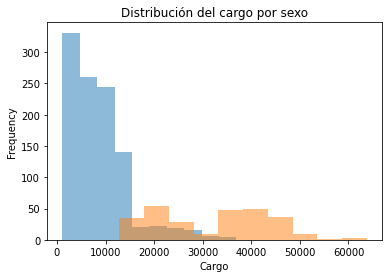

In [202]:
df.groupby('smoker')['charges'].plot(kind='hist',alpha=0.5)
plt.title('Distribución del cargo por sexo')
plt.xlabel('Cargo')
plt.show()

De lo anterior se observa que la correlación lineal con la variable objetivo varía entre grupos. Para algunos grupos son más relevantes algunas variables para determinar el cargo, mientras que para otras no. Por ejemplo, en el caso de los fumadores la variable 'bmi' parecería ser relevante para determinar el cargo, mientras que para los que no son fumadores, no lo es.

Como conlusión del análisis exploratorio, se decide considerar todas las variables como explicativas pero lo ideal sería plantear dos modelos lineales separando fumadores de no fumadores, en base a que la correlación lineal entre las variables explicativas y la variable objetivo difieren entre categorías. Sin embargo, dado que los datos son bastante pocos y si se dividen los grupos serían aún menos para entrenar y probar el modelo, se decide implementar el modelo para todos los datos.

### Paso 3: Tratamiento de las variables

Primero se divide la variable edad en rangos.

In [203]:
X_train['age_rang']=pd.cut(X_train['age'],bins=[10,20,30,40,50,60,70])
X_train['age_rang']=X_train['age_rang'].astype('category')
X_train=X_train.drop(columns='age')

# Replico para la muestra de prueba
X_test['age_rang']=pd.cut(X_test['age'],bins=[10,20,30,40,50,60,70])
X_test['age_rang']=X_test['age_rang'].astype('category')
X_test=X_test.drop(columns='age')

In [204]:
X_train['age_rang'].value_counts()

(40, 50]    228
(20, 30]    227
(30, 40]    208
(50, 60]    208
(10, 20]    123
(60, 70]     76
Name: age_rang, dtype: int64

En segundo lugar es codifican las variables categóricas y escalan las continuas.

In [205]:
X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test) # transformo también las variables para la prueba

In [206]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                1070 non-null   float64
 1   children           1070 non-null   int64  
 2   sex_female         1070 non-null   uint8  
 3   sex_male           1070 non-null   uint8  
 4   smoker_no          1070 non-null   uint8  
 5   smoker_yes         1070 non-null   uint8  
 6   region_northeast   1070 non-null   uint8  
 7   region_northwest   1070 non-null   uint8  
 8   region_southeast   1070 non-null   uint8  
 9   region_southwest   1070 non-null   uint8  
 10  age_rang_(10, 20]  1070 non-null   uint8  
 11  age_rang_(20, 30]  1070 non-null   uint8  
 12  age_rang_(30, 40]  1070 non-null   uint8  
 13  age_rang_(40, 50]  1070 non-null   uint8  
 14  age_rang_(50, 60]  1070 non-null   uint8  
 15  age_rang_(60, 70]  1070 non-null   uint8  
dtypes: float64(1), int64(1),

In [207]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bmi                268 non-null    float64
 1   children           268 non-null    int64  
 2   sex_female         268 non-null    uint8  
 3   sex_male           268 non-null    uint8  
 4   smoker_no          268 non-null    uint8  
 5   smoker_yes         268 non-null    uint8  
 6   region_northeast   268 non-null    uint8  
 7   region_northwest   268 non-null    uint8  
 8   region_southeast   268 non-null    uint8  
 9   region_southwest   268 non-null    uint8  
 10  age_rang_(10, 20]  268 non-null    uint8  
 11  age_rang_(20, 30]  268 non-null    uint8  
 12  age_rang_(30, 40]  268 non-null    uint8  
 13  age_rang_(40, 50]  268 non-null    uint8  
 14  age_rang_(50, 60]  268 non-null    uint8  
 15  age_rang_(60, 70]  268 non-null    uint8  
dtypes: float64(1), int64(1), u

Para realizar la estandarización de las variables continuas se decide aplicar el método estandar a las variables 'bmi'  y 'children', dado que parecería distribuirse al rededor de un centro.

In [208]:
from sklearn.preprocessing import StandardScaler

In [209]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train.select_dtypes(['int','float']))
X_test_sc = sc.transform (X_test.select_dtypes(['int','float']))

In [210]:
X_train['bmi']=pd.DataFrame(X_train_sc,columns=['bmi','children'])['bmi']
X_train['children']=pd.DataFrame(X_train_sc,columns=['bmi','children'])['children']
X_test['bmi']=pd.DataFrame(X_test_sc,columns=['bmi','children'])['bmi']
X_test['children']=pd.DataFrame(X_test_sc,columns=['bmi','children'])['children']

In [211]:
X_train.head(10)

,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,"age_rang_(10, 20]","age_rang_(20, 30]","age_rang_(30, 40]","age_rang_(40, 50]","age_rang_(50, 60]","age_rang_(60, 70]"
0,-0.390595,-0.912822,1,0,0,1,0,0,0,1,1,0,0,0,0,0
1,0.985572,-0.912822,0,1,1,0,0,0,0,1,0,0,0,0,1,0
2,1.089603,0.731487,1,0,1,0,0,1,0,0,0,0,1,0,0,0
3,1.262443,0.731487,0,1,1,0,0,0,1,0,0,0,1,0,0,0
4,-0.622414,-0.912822,1,0,0,1,0,1,0,0,0,0,0,1,0,0
5,0.451488,3.197949,0,1,1,0,0,0,1,0,0,0,1,0,0,0
6,-0.684669,-0.912822,1,0,1,0,1,0,0,0,0,0,0,0,1,0
7,-0.077681,-0.912822,0,1,1,0,0,1,0,0,0,0,0,0,1,0
8,-0.095702,1.553641,1,0,1,0,0,0,0,1,0,1,0,0,0,0
9,0.171340,-0.912822,0,1,1,0,1,0,0,0,0,1,0,0,0,0


In [213]:
y_train.head(10)

0    17081.08000
1     9144.56500
2     5989.52365
3     4463.20510
4    21774.32215
5     6653.78860
6    12815.44495
7    10231.49990
8     4234.92700
9     2254.79670
Name: charges, dtype: float64

### Paso 4: Planteo del modelo

In [159]:
from sklearn.linear_model import LinearRegression

In [221]:
lr = LinearRegression()
lr.fit(X_train,y_train)


LinearRegression()

In [222]:
#Construir un data dataframe para mostrar los coeficiente por cada variable
coeff_df = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coefficient'])  
print(coeff_df)
print("\nIntercepto\t\t: %.6f" % lr.intercept_)#%.6f, queremos 6 decimales luego del punto

                    Coefficient
bmi                 2095.548574
children             755.119636
sex_female            83.947833
sex_male             -83.947833
smoker_no         -11974.310166
smoker_yes         11974.310166
region_northeast     461.913404
region_northwest     563.709147
region_southeast    -541.802643
region_southwest    -483.819909
age_rang_(10, 20]  -4717.490374
age_rang_(20, 30]  -3592.577724
age_rang_(30, 40]  -2575.157926
age_rang_(40, 50]    580.851456
age_rang_(50, 60]   4535.949204
age_rang_(60, 70]   5768.425365

Intercepto		: 20833.811224


**Evaluación del modelo**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [ ]:
y_pred=lr.predict(X_test)
print('10 primeras predicciones:',y_pred[:10])

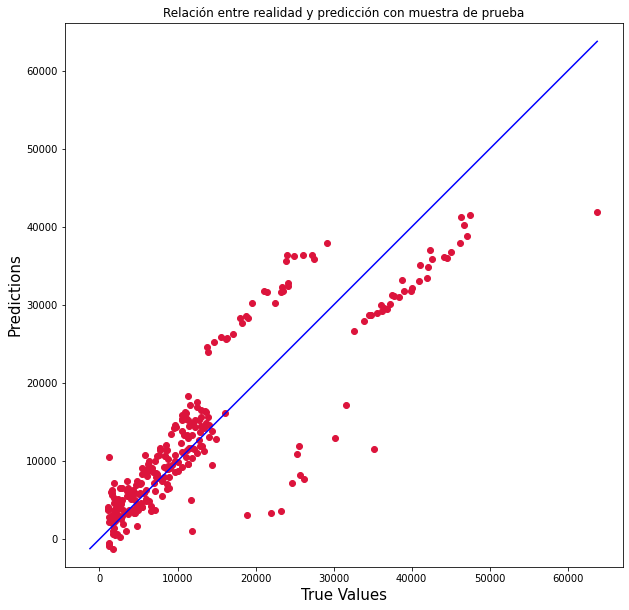

In [219]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Relación entre realidad y predicción con muestra de prueba')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [220]:
# Resultados
print("R^2: %.6f\t" % lr.score(X_train, y_train)) #\t : tabulador

#Calcular el error
print('\nMean squared error\t: %.6f' % mean_squared_error(y_test, y_pred))
print('Coeff. of determination\t: %.6f' % r2_score(y_test, y_pred))

R^2: 0.744682	

Mean squared error	: 35288486.464556
Coeff. of determination	: 0.769241


El R cuadrado indica que el modelo explica en un 74.45 % la variación de la variable objetivo considerando los datos de entrenamiento. Si se considera la bondad de ajuste con respecto a la muestra de prueba, se observa que el ajuste mejora levemente llegando a un 76.92 %. 

Visualmente se puede observar que el modelo estima mejor los costos más bajos que los altos.

**Mejorando el modelo**

Se propone estudiar la significancia de cada coeficiente y así decidir si alguna variable explicativa se puede eliminar del modelo. Para obtener el p-value y la significancia se utiliza la librería de *statsmodels*.

In [227]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_test)
est = sm.OLS(y_test, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     78.02
Date:                Sat, 09 Jul 2022   Prob (F-statistic):           4.22e-78
Time:                        21:36:52   Log-Likelihood:                -2699.0
No. Observations:                 268   AIC:                             5424.
Df Residuals:                     255   BIC:                             5471.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              8582.9883    193.68

Considerando un nivel de significancia de 10% se observa que las variables que no son significativas son 'region_northwest' y 'age_rang_(30, 40]'.

In [229]:
X_train_2=X_train.drop(columns=['region_northwest','age_rang_(30, 40]'])
X_test_2=X_test.drop(columns=['region_northwest','age_rang_(30, 40]'])

In [230]:
lr = LinearRegression()
lr.fit(X_train_2,y_train)

LinearRegression()

In [233]:
# Resultados
print("R^2: %.6f\t" % lr.score(X_train_2, y_train)) #\t : tabulador

R^2: 0.744682	

Mean squared error	: 35288486.464556
Coeff. of determination	: 0.769241


In [236]:
y_pred_2=lr.predict(X_test_2)

#Calcular el error
print('\nMean squared error\t: %.6f' % mean_squared_error(y_test, y_pred_2))
print('Coeff. of determination\t: %.6f' % r2_score(y_test, y_pred_2))


Mean squared error	: 35288486.464556
Coeff. of determination	: 0.769241


En conclusión, la elminación de las variables no significativas no mejora la bondad de ajuste del modelo. Sin embargo, considerando el principio de persimonia optaría por el modelo con menor cantidad de variables explicativas.

In [239]:
import pickle
filename = '/workspace/Linear-model-Regression/models/finalized_model.sav'
pickle.dump(lr, open(filename, 'wb'))